# Aula 8 - Random Search

Na aula de hoje, vamos explorar os seguintes tópicos em Python

- 1) breve revisão sobre o GridSearch para seleção de hiperparâmetros
- 2) RandomSearch como uma ferramenta alternativa ao GridSearch

_____

# 1) GridSearch (revisão)

Conforme já vimos, o GridSearch é um método proporcionado pelo módulo *scikit-learn* para seleção de hiperparâmetros, representando a **busca exaustiva de hiperparâmetros** de um estimador.

Ele faz isso por meio do treinamento de **diversos modelos com diferentes combinações de hiperparâmetros**, e vai salvando os resultados de desempenho - medidos por um *scoring*. Ao final do processo, a melhor combinação (aquela com o melhor valor da métrica) de hiperparâmetros é selecionada. O *scikit-learn* ainda apresenta a possibilidade de fazer essa avaliação usando validação cruzada - GriSearchCV, o que aumenta a robustez estatística e a confiabilidade dos resultados obtidos.

Para encontrar mais informações sobre os *scorings* utilizados, você pode usar o [LINK](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

Para utilizar quaisquer umas das técnicas, devemos informar a grade.

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

O argumento mais comum de ser passado ao GridSearchCV é o **Pipeline**, onde podemos agrupar várias operações sequenciais sobre os dados. Mais informações podem ser checadas [nesse link](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

________

# 2) Random Search

O GridSearch é um excelente método para buscar hiperparâmetros de um estimador, mas tem dois principais pontos fracos:

- E se a combinação "ótima" de hiperparâmetros não estiver dentro da grade especificada? Nesse caso, o GridSearch vai chegar numa solução boa, mas não podemos garantir de fato que ela seja a melhor, visto que ele nunca vai estar olhando para a região correta.
- Para resolver a questão anterior, e se nós aumentássemos a grade informada para "cobrir uma área maior"? Nesse caso teríamos um problema de *explosão combinatória*. Vejamos um caso de dois hiperparâmetros de caráter contínuo:
    - Se cada um deles assumir 5 valores, temos 25 experimentos (que pode ser multiplicado por 5 ou 10, dependendo do cross validation que usarmos).
    - Se cada um deles assumir 10 valores, esse valor sobe para 100 experimentos
    - Se cada um deles assumir 20 valores, temos 400 experimentos
    - Para 40 valores, 1600.
    - 80 valores, 6400
    - ...
Para uma variável contínua, ela pode assumir infinitos valores, então para garantir matematicamente que vamos encontrar a solução ótima, temos de explorar infinitas possibilidades, algo que não possuímos tempo ou recursos computacionais para conseguir.
- Um terceiro ponto que precisamos ter em mente é mais voltado para o ponto de vista do negócio. Mesmo que algumas combinações sejam exploradas no GridSearch, pode ser que elas nem seja de interesse do negócio. Ainda assim, o método "gasta recursos computacionais" para explorar essas soluções.

É nesse contexto que entra o método de **Random Search** ou Busca Aleatória.

Ao invés de realizar uma busca bruta, onde todas as combinações são exploradas, o RandomSearch realiza uma amostragem aleatória de valores dos hiperparâmetros informados e somente depois realiza as combinações para o experimentador avaliar segundo o scoring.

<img src="https://miro.medium.com/max/1400/1*9W1MrRkHi0YFmBoHi9Y2Ow.png" width=500>

In [118]:
import warnings
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, \
    make_scorer

# ignorar warnings
warnings.filterwarnings('ignore')


In [4]:
# realizar a leitura dos dados
data = pd.read_csv('../datasets/breast_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# checando nos tipos dos dados para verificar variáveis categóricas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
# eliminar a coluna 'ID'
data.drop(['id'], axis = 1, inplace=True)

# separar entre preditores e target
x = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

# separar um conjunto de validação final
x_train, x_test,  y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, 
                                    stratify=y)

In [7]:
# checando desbalanceamento
y.value_counts(normalize=True)

diagnosis
B            0.627417
M            0.372583
dtype: float64

In [8]:
# checando balanceamento na base de treino
y_train.value_counts(normalize=True)

diagnosis
B            0.626374
M            0.373626
dtype: float64

In [11]:
# checando balanceamento na base de teste
y_test.value_counts(normalize=True)

diagnosis
B            0.631579
M            0.368421
dtype: float64

### Random Forest

In [12]:
# construir o pipeline
steps = [('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(random_state = 42))]
pipe = Pipeline(steps)

# construir o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(f1_score, pos_label = 'M')

# construir um dicionário de parâmetros
param_dict = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10, 15, 20],
    'model__n_estimators': [20, 50, 100, 200, 500, 1000]
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, n_iter=20, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=50
[CV 1/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=50;, score=0.970 total time=   0.0s
[CV 2/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=50
[CV 2/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=50;, score=0.909 total time=   0.0s
[CV 3/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=50
[CV 3/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=50;, score=1.000 total time=   0.0s
[CV 4/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=50
[CV 4/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=50;, score=1.000 total time=   0.0s
[CV 5/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n

[CV 3/10; 5/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 4/10; 5/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 4/10; 5/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 5/10; 5/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 5/10; 5/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 6/10; 5/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 6/10; 5/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 7/10; 5/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 7/10; 5/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 8/10; 5/20] ST

[CV 2/10; 9/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=1000;, score=0.875 total time=   1.3s
[CV 3/10; 9/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=1000
[CV 3/10; 9/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=1000;, score=1.000 total time=   1.2s
[CV 4/10; 9/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=1000
[CV 4/10; 9/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=1000;, score=1.000 total time=   1.2s
[CV 5/10; 9/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=1000
[CV 5/10; 9/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=1000;, score=0.882 total time=   1.3s
[CV 6/10; 9/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=1000
[CV 6/10; 9/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=1000;, score=0.938 total time=   1.4s
[CV 7/10; 9/20] START mode

[CV 1/10; 13/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=500;, score=1.000 total time=   0.6s
[CV 2/10; 13/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=500
[CV 2/10; 13/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=500;, score=0.875 total time=   0.6s
[CV 3/10; 13/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=500
[CV 3/10; 13/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=500;, score=1.000 total time=   0.6s
[CV 4/10; 13/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=500
[CV 4/10; 13/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=500;, score=1.000 total time=   0.6s
[CV 5/10; 13/20] START model__criterion=gini, model__max_depth=10, model__n_estimators=500
[CV 5/10; 13/20] END model__criterion=gini, model__max_depth=10, model__n_estimators=500;, score=0.882 total time=   0.6s
[CV 6/10; 13/20] START mod

[CV 9/10; 16/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 10/10; 16/20] START model__criterion=entropy, model__max_depth=10, model__n_estimators=100
[CV 10/10; 16/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=0.970 total time=   0.1s
[CV 1/10; 17/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 1/10; 17/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=1.000 total time=   0.2s
[CV 2/10; 17/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 2/10; 17/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=0.875 total time=   0.2s
[CV 3/10; 17/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 3/10; 17/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=1.000 total time=   0.2s
[CV 4/10; 17/20

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20,
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [5, 10, 15, 20],
                                        'model__n_estimators': [20, 50, 100,
                                                                200, 500,
                                                                1000]},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [13]:
print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica Média:')
print(rs_cv.best_score_)

Melhores Parâmetros:
{'model__n_estimators': 50, 'model__max_depth': 15, 'model__criterion': 'entropy'}
Melhor Métrica Média:
0.9510408811618489


In [15]:
y_pred = rs_cv.predict(x_test)

              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



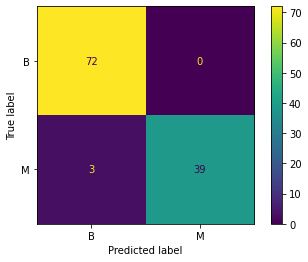

In [17]:
# relatório de classificação
print(classification_report(y_test, y_pred))

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Conteúdos Extras

### Oversampling com SMOTE -> Synthetic Minority Oversampling Technique


In [19]:
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline


In [23]:
# eliminar a coluna 'ID'
data.drop(['id'], axis = 1, inplace=True)

# separar entre preditores e target
x = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

# separar um conjunto de validação final
x_train, x_test,  y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, 
                                    stratify=y)



In [25]:
smote = SMOTE(random_state=42)

In [27]:
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [30]:
y_train_smote.value_counts()

diagnosis
B            285
M            285
dtype: int64

In [33]:
#construir o pipeline
steps = [('smote', SMOTE()),
         ('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(random_state = 42))]

pipe = imbpipeline(steps)

# construir o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(f1_score, pos_label = 'M')

# construir um dicionário de parâmetros
param_dict = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10, 15, 20],
    'model__n_estimators': [20, 50, 100, 200, 500, 1000]
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, n_iter=20, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=500
[CV 1/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=500;, score=1.000 total time=   0.8s
[CV 2/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=500
[CV 2/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=500;, score=0.909 total time=   0.8s
[CV 3/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=500
[CV 3/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=500;, score=0.971 total time=   0.8s
[CV 4/10; 1/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=500
[CV 4/10; 1/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=500;, score=1.000 total time=   0.7s
[CV 5/10; 1/20] START model__criterion=entropy, model__max_depth=15, 

[CV 10/10; 4/20] END model__criterion=entropy, model__max_depth=5, model__n_estimators=100;, score=0.941 total time=   0.1s
[CV 1/10; 5/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=100
[CV 1/10; 5/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 2/10; 5/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=100
[CV 2/10; 5/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=100;, score=0.909 total time=   0.1s
[CV 3/10; 5/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=100
[CV 3/10; 5/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=100;, score=0.944 total time=   0.1s
[CV 4/10; 5/20] START model__criterion=entropy, model__max_depth=15, model__n_estimators=100
[CV 4/10; 5/20] END model__criterion=entropy, model__max_depth=15, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 5/10

[CV 1/10; 9/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000;, score=nan total time=   0.1s
[CV 2/10; 9/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000
[CV 2/10; 9/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000;, score=nan total time=   0.2s
[CV 3/10; 9/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000
[CV 3/10; 9/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000;, score=nan total time=   0.2s
[CV 4/10; 9/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000
[CV 4/10; 9/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000;, score=nan total time=   0.2s
[CV 5/10; 9/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000
[CV 5/10; 9/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=1000;, score=nan total time=   0.2s


[CV 10/10; 12/20] END model__criterion=entropy, model__max_depth=20, model__n_estimators=50;, score=0.941 total time=   0.0s
[CV 1/10; 13/20] START model__criterion=entropy, model__max_depth=10, model__n_estimators=100
[CV 1/10; 13/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 2/10; 13/20] START model__criterion=entropy, model__max_depth=10, model__n_estimators=100
[CV 2/10; 13/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=0.909 total time=   0.1s
[CV 3/10; 13/20] START model__criterion=entropy, model__max_depth=10, model__n_estimators=100
[CV 3/10; 13/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=0.971 total time=   0.1s
[CV 4/10; 13/20] START model__criterion=entropy, model__max_depth=10, model__n_estimators=100
[CV 4/10; 13/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=1.000 total time=   0.1s

[CV 8/10; 16/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 9/10; 16/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=100
[CV 9/10; 16/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 10/10; 16/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=100
[CV 10/10; 16/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/10; 17/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=500
[CV 1/10; 17/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=500;, score=nan total time=   0.0s
[CV 2/10; 17/20] START model__criterion=log_loss, model__max_depth=10, model__n_estimators=500
[CV 2/10; 17/20] END model__criterion=log_loss, model__max_depth=10, model__n_estimators=500;, score=nan total time=   0.0

[CV 7/10; 20/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 8/10; 20/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 8/10; 20/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 9/10; 20/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 9/10; 20/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 10/10; 20/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 10/10; 20/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20,
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [5, 10, 15, 20],
                                        'model__n_estimators': [20, 50, 100,
                                                                200, 500,
                                                                1000]},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [34]:
y_pred = rs_cv.predict(x_test)

              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



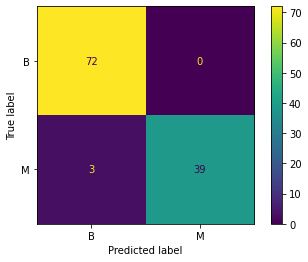

In [35]:
# relatório de classificação
print(classification_report(y_test, y_pred))

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Feature selection

In [37]:

# separar entre preditores e target
x = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

# separar um conjunto de validação final
x_train, x_test,  y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, 
                                    stratify=y)



In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [40]:
x

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [41]:
select = SelectKBest(score_func = chi2, k=15)

In [42]:
z = select.fit_transform(x,y)

In [57]:
select.scores_

array([2.66104917e+02, 9.38975081e+01, 2.01110286e+03, 5.39916559e+04,
       1.49899264e-01, 5.40307549e+00, 1.97123536e+01, 1.05440354e+01,
       2.57379775e-01, 7.43065536e-05, 3.46752472e+01, 9.79353970e-03,
       2.50571896e+02, 8.75850471e+03, 3.26620664e-03, 6.13785332e-01,
       1.04471761e+00, 3.05231563e-01, 8.03633831e-05, 6.37136566e-03,
       4.91689157e+02, 1.74449400e+02, 3.66503542e+03, 1.12598432e+05,
       3.97365694e-01, 1.93149220e+01, 3.95169151e+01, 1.34854195e+01,
       1.29886140e+00, 2.31522407e-01])

In [46]:
filtered_columns = select.get_support()

In [55]:
x = x[x.columns[filtered_columns]]

In [56]:
#construir o pipeline
steps = [('smote', SMOTE()),
         ('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(random_state = 42))]

pipe = imbpipeline(steps)

# construir o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(f1_score, pos_label = 'M')

# construir um dicionário de parâmetros
param_dict = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10, 15, 20],
    'model__n_estimators': [20, 50, 100, 200, 500, 1000]
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, n_iter=20, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 1/10; 1/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 2/10; 1/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 2/10; 1/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 3/10; 1/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 3/10; 1/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 4/10; 1/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=50
[CV 4/10; 1/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=50;, score=nan total time=   0.0s
[CV 5/10; 1/20] START model__criterion=log_loss, model__max_depth=15, model__

[CV 10/10; 4/20] END model__criterion=entropy, model__max_depth=10, model__n_estimators=100;, score=0.970 total time=   0.1s
[CV 1/10; 5/20] START model__criterion=entropy, model__max_depth=5, model__n_estimators=100
[CV 1/10; 5/20] END model__criterion=entropy, model__max_depth=5, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 2/10; 5/20] START model__criterion=entropy, model__max_depth=5, model__n_estimators=100
[CV 2/10; 5/20] END model__criterion=entropy, model__max_depth=5, model__n_estimators=100;, score=0.909 total time=   0.1s
[CV 3/10; 5/20] START model__criterion=entropy, model__max_depth=5, model__n_estimators=100
[CV 3/10; 5/20] END model__criterion=entropy, model__max_depth=5, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 4/10; 5/20] START model__criterion=entropy, model__max_depth=5, model__n_estimators=100
[CV 4/10; 5/20] END model__criterion=entropy, model__max_depth=5, model__n_estimators=100;, score=0.971 total time=   0.1s
[CV 5/10; 5/20]

[CV 1/10; 9/20] END model__criterion=entropy, model__max_depth=20, model__n_estimators=100;, score=0.971 total time=   0.1s
[CV 2/10; 9/20] START model__criterion=entropy, model__max_depth=20, model__n_estimators=100
[CV 2/10; 9/20] END model__criterion=entropy, model__max_depth=20, model__n_estimators=100;, score=0.909 total time=   0.1s
[CV 3/10; 9/20] START model__criterion=entropy, model__max_depth=20, model__n_estimators=100
[CV 3/10; 9/20] END model__criterion=entropy, model__max_depth=20, model__n_estimators=100;, score=0.944 total time=   0.1s
[CV 4/10; 9/20] START model__criterion=entropy, model__max_depth=20, model__n_estimators=100
[CV 4/10; 9/20] END model__criterion=entropy, model__max_depth=20, model__n_estimators=100;, score=1.000 total time=   0.1s
[CV 5/10; 9/20] START model__criterion=entropy, model__max_depth=20, model__n_estimators=100
[CV 5/10; 9/20] END model__criterion=entropy, model__max_depth=20, model__n_estimators=100;, score=0.914 total time=   0.1s
[CV 6/10

[CV 10/10; 12/20] END model__criterion=gini, model__max_depth=5, model__n_estimators=200;, score=0.941 total time=   0.2s
[CV 1/10; 13/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=50
[CV 1/10; 13/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=50;, score=1.000 total time=   0.0s
[CV 2/10; 13/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=50
[CV 2/10; 13/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=50;, score=0.909 total time=   0.0s
[CV 3/10; 13/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=50
[CV 3/10; 13/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=50;, score=0.944 total time=   0.0s
[CV 4/10; 13/20] START model__criterion=gini, model__max_depth=20, model__n_estimators=50
[CV 4/10; 13/20] END model__criterion=gini, model__max_depth=20, model__n_estimators=50;, score=1.000 total time=   0.0s
[CV 5/10; 13/20] START model__crit

[CV 1/10; 17/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/10; 17/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 2/10; 17/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/10; 17/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 3/10; 17/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/10; 17/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 4/10; 17/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/10; 17/20] START model__criterion=log_loss, model__max_depth=15, model__n_estimators=100
[CV 5/10; 17/20] END model__criterion=log_loss, model__max_depth=15, model__n_estimators=100;, score=nan total time=   0.0s


[CV 9/10; 20/20] END model__criterion=log_loss, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.1s
[CV 10/10; 20/20] START model__criterion=log_loss, model__max_depth=5, model__n_estimators=1000
[CV 10/10; 20/20] END model__criterion=log_loss, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.2s


KeyError: 'log_loss'

## One Hot encoder

In [59]:
df = pd.read_csv('../datasets/insurance.csv')

In [142]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error

In [145]:
df['region']

0       southwest
1       southeast
2       southeast
3       northwest
4       northwest
          ...    
1333    northwest
1334    northeast
1335    southeast
1336    southwest
1337    northwest
Name: region, Length: 1338, dtype: object

In [120]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), ['sex', 'smoker', 'region']),
    remainder='passthrough'
)

In [121]:
transformed = transformer.fit_transform(df)

In [122]:
transformed

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        2.79000000e+01, 0.00000000e+00, 1.68849240e+04],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.37700000e+01, 1.00000000e+00, 1.72555230e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.30000000e+01, 3.00000000e+00, 4.44946200e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.68500000e+01, 0.00000000e+00, 1.62983350e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.58000000e+01, 0.00000000e+00, 2.00794500e+03],
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.90700000e+01, 0.00000000e+00, 2.91413603e+04]])

In [123]:
transformed = pd.DataFrame(transformed, columns=transformer.get_feature_names())

In [124]:
transformed.head()

,onehotencoder__x0_male,onehotencoder__x1_yes,onehotencoder__x2_northwest,onehotencoder__x2_southeast,onehotencoder__x2_southwest,age,bmi,children,charges
0,0.0,1.0,0.0,0.0,1.0,19.0,27.900,0.0,16884.92400
1,1.0,0.0,0.0,1.0,0.0,18.0,33.770,1.0,1725.55230
2,1.0,0.0,0.0,1.0,0.0,28.0,33.000,3.0,4449.46200
3,1.0,0.0,1.0,0.0,0.0,33.0,22.705,0.0,21984.47061
4,1.0,0.0,1.0,0.0,0.0,32.0,28.880,0.0,3866.85520


In [127]:
x = transformed.drop('charges', axis=1)
y = transformed['charges']

x_train, x_test,  y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [139]:
#construir o pipeline
steps = [('scaler', StandardScaler()), 
         ('model', RandomForestRegressor(random_state = 42))]

pipe = Pipeline(steps)

# construir o amostrador dos folds
cvs = KFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(r2_score)

# construir um dicionário de parâmetros
param_dict = {
    'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'model__max_depth': [5, 10, 15, 20],
    'model__n_estimators': [20, 50, 100, 200, 500, 1000]
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, n_iter=10, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__criterion=squared_error, model__max_depth=15, model__n_estimators=500
[CV 1/10; 1/10] END model__criterion=squared_error, model__max_depth=15, model__n_estimators=500;, score=0.819 total time=   0.9s
[CV 2/10; 1/10] START model__criterion=squared_error, model__max_depth=15, model__n_estimators=500
[CV 2/10; 1/10] END model__criterion=squared_error, model__max_depth=15, model__n_estimators=500;, score=0.779 total time=   0.9s
[CV 3/10; 1/10] START model__criterion=squared_error, model__max_depth=15, model__n_estimators=500
[CV 3/10; 1/10] END model__criterion=squared_error, model__max_depth=15, model__n_estimators=500;, score=0.813 total time=   0.9s
[CV 4/10; 1/10] START model__criterion=squared_error, model__max_depth=15, model__n_estimators=500
[CV 4/10; 1/10] END model__criterion=squared_error, model__max_depth=15, model__n_estimators=500;, score=0.830 total time=   0.9s
[CV 5/10; 1/10] START

[CV 6/10; 4/10] END model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000;, score=0.890 total time=   2.0s
[CV 7/10; 4/10] START model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000
[CV 7/10; 4/10] END model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000;, score=0.792 total time=   2.1s
[CV 8/10; 4/10] START model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000
[CV 8/10; 4/10] END model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000;, score=0.821 total time=   2.1s
[CV 9/10; 4/10] START model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000
[CV 9/10; 4/10] END model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000;, score=0.812 total time=   2.0s
[CV 10/10; 4/10] START model__criterion=friedman_mse, model__max_depth=20, model__n_estimators=1000
[CV 10/10; 4/10] END model__criterion=friedman_mse, model__max_depth=20, model__n_e

[CV 4/10; 8/10] END model__criterion=squared_error, model__max_depth=5, model__n_estimators=50;, score=0.861 total time=   0.0s
[CV 5/10; 8/10] START model__criterion=squared_error, model__max_depth=5, model__n_estimators=50
[CV 5/10; 8/10] END model__criterion=squared_error, model__max_depth=5, model__n_estimators=50;, score=0.857 total time=   0.0s
[CV 6/10; 8/10] START model__criterion=squared_error, model__max_depth=5, model__n_estimators=50
[CV 6/10; 8/10] END model__criterion=squared_error, model__max_depth=5, model__n_estimators=50;, score=0.932 total time=   0.0s
[CV 7/10; 8/10] START model__criterion=squared_error, model__max_depth=5, model__n_estimators=50
[CV 7/10; 8/10] END model__criterion=squared_error, model__max_depth=5, model__n_estimators=50;, score=0.797 total time=   0.0s
[CV 8/10; 8/10] START model__criterion=squared_error, model__max_depth=5, model__n_estimators=50
[CV 8/10; 8/10] END model__criterion=squared_error, model__max_depth=5, model__n_estimators=50;, sco

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'model__criterion': ['squared_error',
                                                             'absolute_error',
                                                             'friedman_mse'],
                                        'model__max_depth': [5, 10, 15, 20],
                                        'model__n_estimators': [20, 50, 100,
                                                                200, 500,
                                                                1000]},
                   scoring=make_scorer(r2_score), verbose=10)

In [140]:
y_pred = rs_cv.predict(x_test)

In [144]:
print(r2_score(y_pred, y_test))

0.8593017386632535
